In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Inversion

### Example with Exponential distribution

In [5]:
# beta = 1 / lambda
beta = 0.1
size = 10000

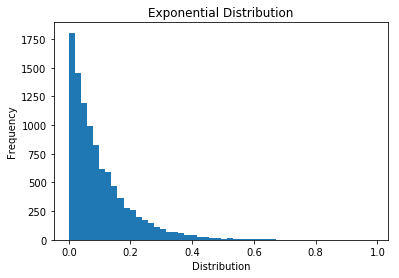

In [17]:
X = np.random.exponential(beta, size=size)

plt.title("Exponential Distribution")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(X, bins=50);

Inversion of the Cumulative Distribution Function :

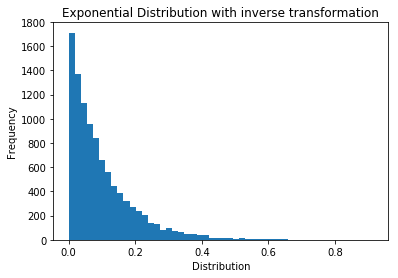

In [55]:
Y = - beta * np.log(np.random.uniform(size=size))

plt.title("Exponential Distribution with inverse transformation")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(Y, bins=50);

## Rejection

Suppose we have some observations from the density we want to generate

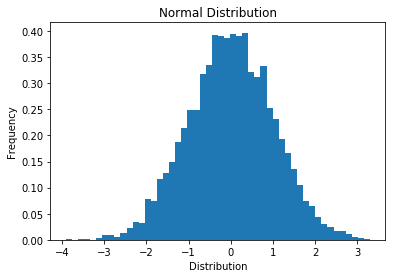

In [52]:
X = np.random.normal(size=size)

plt.title("Normal Distribution")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(X, density=True, bins=50);

In [ ]:
def f(x):
    """
    Compute normal density
    """
    return 1/np.sqrt(2*np.pi) * np.exp(-1/2*x**2)

def g(x):
    """
    Computer Cauchy distribution density
    """
    return 1/(np.pi*(1+x**2))

5959


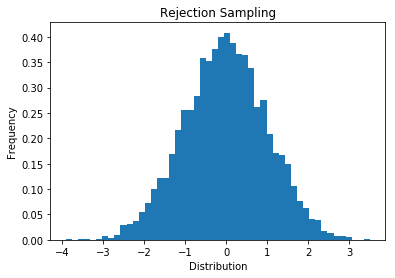

In [59]:
M = 1.7
Y = np.random.standard_cauchy(size=size)
U = np.random.uniform(size=size)

generated_sample = [y for u,y in zip(U,Y) if u <= f(y)/(M*g(y))]

plt.title("Rejection Sampling")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(generated_sample, density=True, bins=50);

## Chain Rule